# Importing the Packages

In [1]:
import os
import glob
import cv2 #opencv
import numpy as np
import pandas as pd
import random
import warnings
import warnings
warnings.filterwarnings('ignore')


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Handling
from PIL import Image

# Scikit-learn for preprocessing, metrics, and splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, classification_report,
    confusion_matrix, roc_curve, auc
)

# TensorFlow / Keras for deep learning models and layers
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess


2025-04-19 00:16:52.034457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Reading the image Dataset and Preprocessing the Images 

In [2]:
directory = os.path.expanduser("~/Desktop/project_brain_tumor_detection/brain_tumor_dataset")
categories = ['no', 'yes']

# Supported image formats
image_formats = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.JPG']

# Counting total images for each category
total_images = 0

for category in categories:
    folder_path = os.path.join(directory, category)
    image_count = 0
    for img_format in image_formats:
        # Count all images with each format in the folder
        image_count += len(glob.glob(os.path.join(folder_path, img_format)))
    
    total_images += image_count
    print(f"{category} images: {image_count}")

print(f"Total images: {total_images}")

# Loading and processing images
tumor, no_tumor = [], []

for category in categories:
    folder_path = os.path.join(directory, category)
    for img_format in image_formats:
        # Loop through each image format
        for file in glob.iglob(os.path.join(folder_path, img_format)):
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))

            label = 1 if category == 'yes' else 0
            (tumor if label == 1 else no_tumor).append((img, label))

# Combining and shuffle
all_data = tumor + no_tumor
np.random.shuffle(all_data)

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])


no images: 98
yes images: 155
Total images: 253


# Exploratory Data Analysis (EDA)

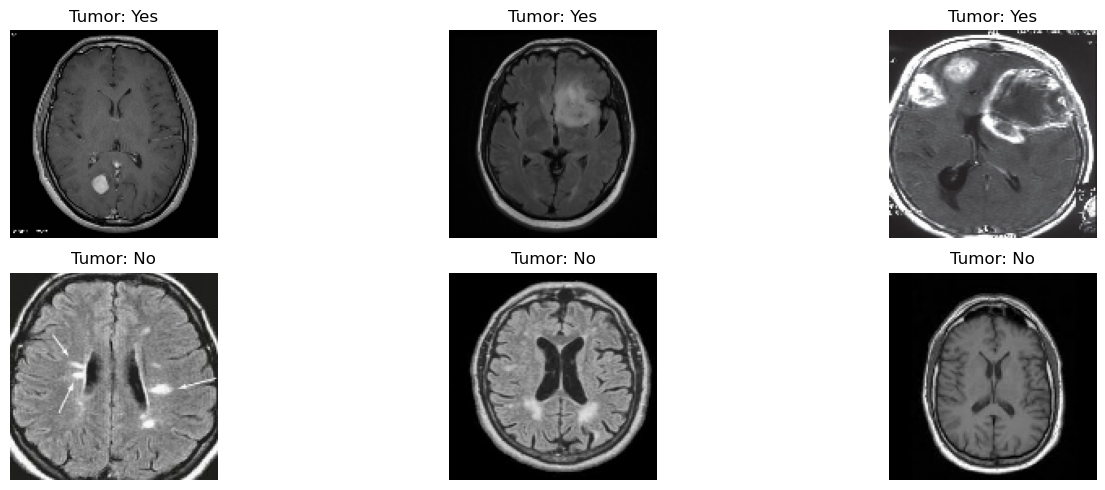

In [3]:
import matplotlib.pyplot as plt

# Sample images
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(2, 3, i+1)  # First row for 'yes' tumor images
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')
for i in range(3):
    plt.subplot(2, 3, i+4)  # Second row for 'no' tumor images
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()


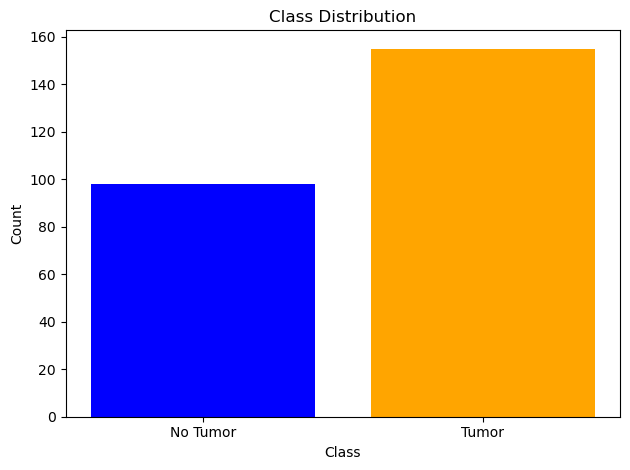

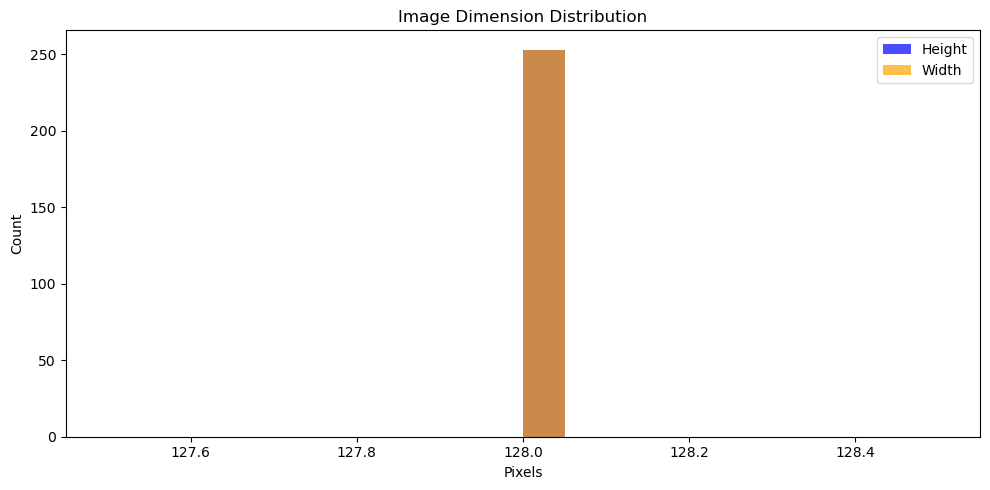

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Class distribution bar chart
unique_labels, label_counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

# Image size check
plt.figure(figsize=(10, 5))
heights = [img.shape[0] for img in data]
widths = [img.shape[1] for img in data]

# Plot histograms for image heights and widths
plt.hist(heights, bins=20, alpha=0.7, label='Height', color='blue')
plt.hist(widths, bins=20, alpha=0.7, label='Width', color='orange')
plt.title("Image Dimension Distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


# Splitting & Normalizing Dataset

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalizing for base model
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0


In [6]:
print("Training set count:", len(x_train))
print("Test set count:", len(x_test))


Training set count: 202
Test set count: 51


In [7]:
print(f"Training images: {len(x_train)}")
print(f"Training labels: {len(y_train)}")
print(f"Test images: {len(x_test)}")
print(f"Test labels: {len(y_test)}")


Training images: 202
Training labels: 202
Test images: 51
Test labels: 51


# Data Augumentation

In [8]:
BATCH_SIZE = 32

# Adding Image augmentation to our generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=(0.75,1),
                                   brightness_range=(0.75,1.25)
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle= False)

In [9]:
# Creating checkpoint callback
checkpoint_path = "brain_tumor_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setuping EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watching the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Traning the Convolution Neural Network (CNN) Model

In [10]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=cnn.fit(x_train_norm, y_train, epochs=20, validation_split=0.2)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.5870 - loss: 0.8542 - val_accuracy: 0.8049 - val_loss: 0.5349
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - accuracy: 0.7243 - loss: 0.5855 - val_accuracy: 0.8049 - val_loss: 0.4993
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.7826 - loss: 0.5351 - val_accuracy: 0.7805 - val_loss: 0.4981
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.7728 - loss: 0.5193 - val_accuracy: 0.8049 - val_loss: 0.4542
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - accuracy: 0.7562 - loss: 0.5135 - val_accuracy: 0.8537 - val_loss: 0.4187
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.8289 - loss: 0.4291 - val_accuracy: 0.8049 - val_loss: 0.4518
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.7603 - loss: 0.4897 - val_accuracy: 0.7561 - val_loss: 0.5214
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.7390 - loss: 0.5658 - val_accuracy: 0.7561 - val_loss:

# Evaluating the Model Performance, Confusion matrix & ROC Curve

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7024 - loss: 0.7197
Test Loss: 0.6914427280426025
Test Accuracy: 0.7254902124404907
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


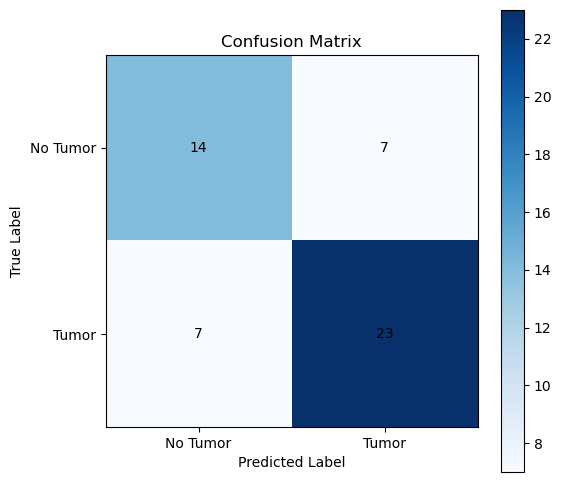

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.67      0.67      0.67        21
       Tumor       0.77      0.77      0.77        30

    accuracy                           0.73        51
   macro avg       0.72      0.72      0.72        51
weighted avg       0.73      0.73      0.73        51



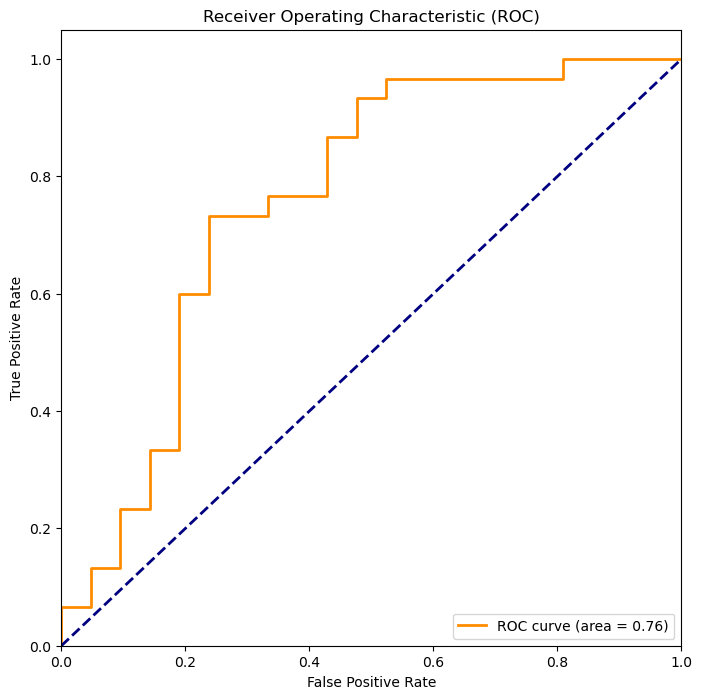

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

# Evaluating model performance
test_loss, test_acc = cnn.evaluate(x_test_norm, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Generating predictions for ROC Curve, Confusion Matrix, and Precision-Recall Curve
y_pred = cnn.predict(x_test_norm)
y_pred_binary = (y_pred > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['No Tumor', 'Tumor'])
plt.yticks([0, 1], ['No Tumor', 'Tumor'])

# Adding the numbers to the matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")

plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['No Tumor', 'Tumor']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()



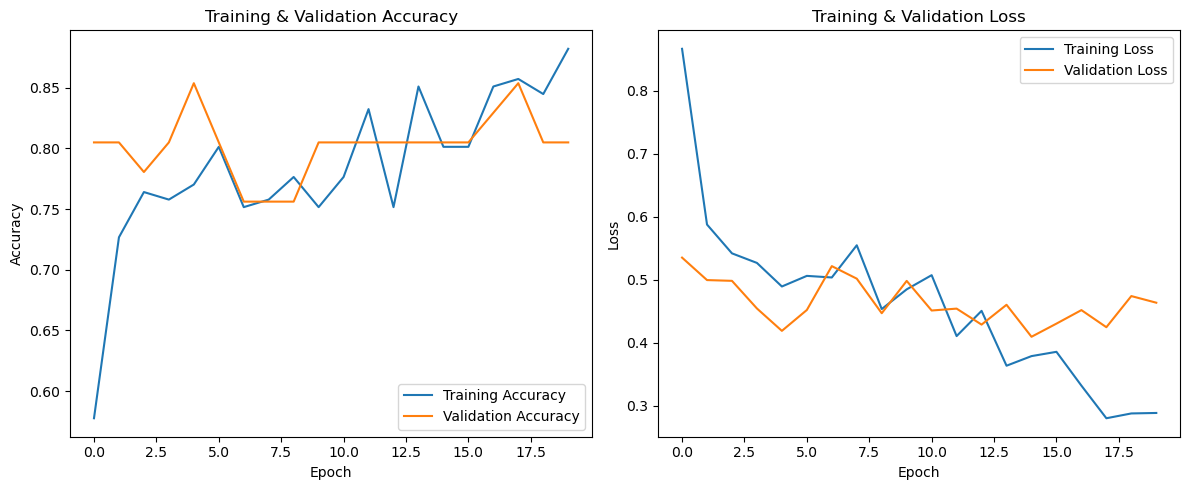

In [12]:
import matplotlib.pyplot as plt

# Accuracy curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Transfer Learning Techniques


# Traning VGG16 Modules

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Loading the pre-trained VGG16 model without the top (classification) layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the layers of VGG16 so that they are not trained again
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Adding custom layers on top of the VGG16 model
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Final model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=x)

# Compile the model
model_vgg16.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_vgg16.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# Training the VGG16 model
history_vgg16 = model_vgg16.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5656 - loss: 3.3321 - val_accuracy: 0.7647 - val_loss: 1.1220
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7646 - loss: 1.3562 - val_accuracy: 0.7843 - val_loss: 0.8442
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7556 - loss: 1.4360 - val_accuracy: 0.8235 - val_loss: 0.9930
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8045 - loss: 1.1099 - val_accuracy: 0.8039 - val_loss: 0.7275
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8253 - loss: 1.0318 - val_accuracy: 0.8235 - val_loss: 0.8197
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8596 - loss: 0.7949 - val_accuracy: 0.8235 - val_loss: 0.8528
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8913 - loss: 0.4793 - val_accuracy: 0.8235 - val_loss: 0.6833
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8995 - loss: 0.3802 - val_accuracy: 0.8235 - val_loss: 0.5913
Epoch 9/

# Confusion Matrix :- VGG16

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


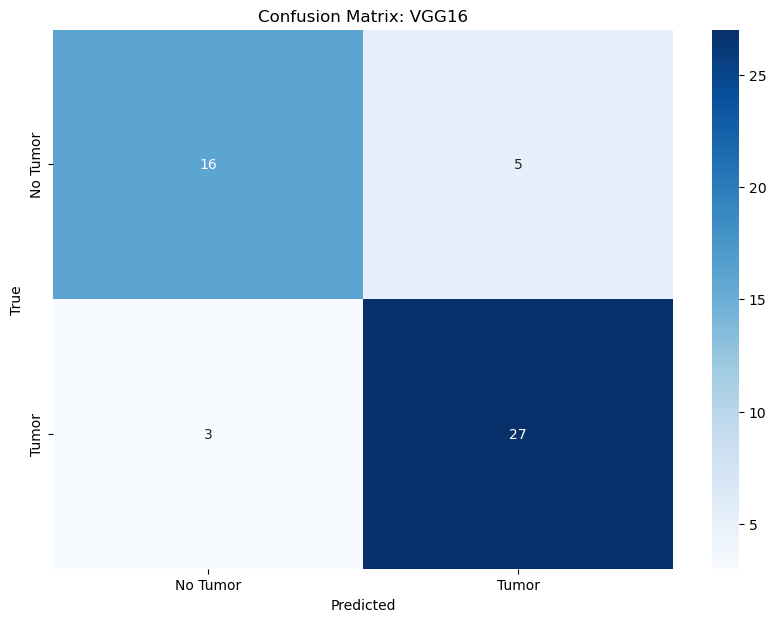

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For VGG16
y_pred_vgg16 = (model_vgg16.predict(x_test) > 0.5)
cm_vgg16 = confusion_matrix(y_test, y_pred_vgg16)

# Plot confusion matrix for VGG16
plt.figure(figsize=(10, 7))
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title("Confusion Matrix: VGG16")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# VGG16 Accuracy and Loss

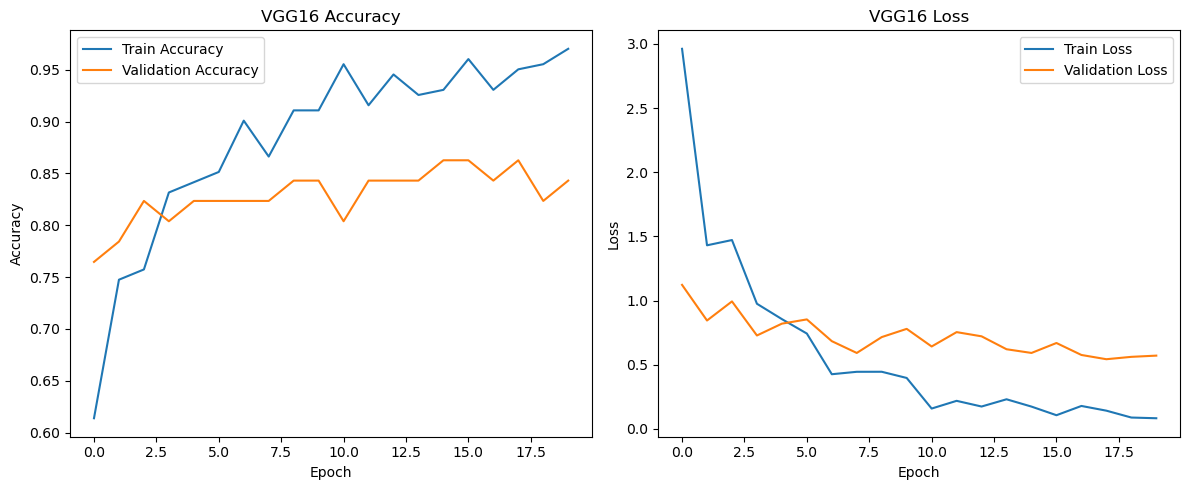

In [16]:
# VGG16 Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 885ms/step


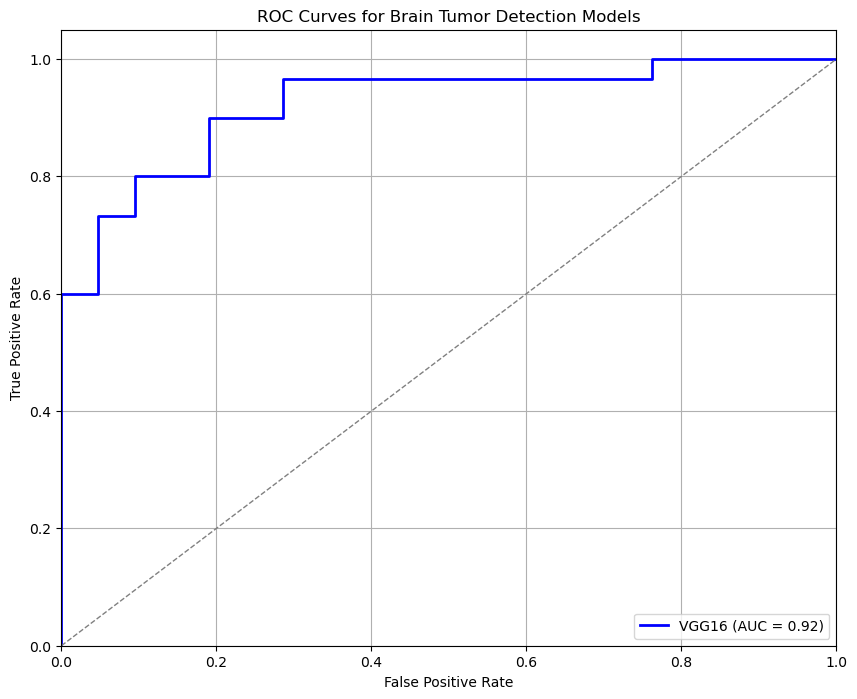

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# For VGG16
y_pred_vgg16_prob = model_vgg16.predict(x_test)  # predicted probabilities
fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(y_test, y_pred_vgg16_prob)
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

# Plotting all ROC curves
plt.figure(figsize=(10, 8))

# VGG16 ROC curve
plt.plot(fpr_vgg16, tpr_vgg16, color='blue', lw=2, label=f'VGG16 (AUC = {roc_auc_vgg16:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Brain Tumor Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Training the Resnet50 Model

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Loading the pre-trained ResNet50 model without the top (classification) layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the layers of ResNet50
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Adding custom layers on top
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Final model
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=x)

# Compile the model
model_resnet50.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_resnet50.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
# Training the ResNet50 model
history_resnet50 = model_resnet50.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5467 - loss: 1.5463 - val_accuracy: 0.5882 - val_loss: 0.7317
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 912ms/step - accuracy: 0.5926 - loss: 0.7779 - val_accuracy: 0.7843 - val_loss: 0.4216
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 696ms/step - accuracy: 0.8127 - loss: 0.3929 - val_accuracy: 0.8627 - val_loss: 0.3067
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 712ms/step - accuracy: 0.9084 - loss: 0.3074 - val_accuracy: 0.8627 - val_loss: 0.2684
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 720ms/step - accuracy: 0.9048 - loss: 0.2743 - val_accuracy: 0.8824 - val_loss: 0.2789
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 723ms/step - accuracy: 0.9144 - loss: 0.2458 - val_accuracy: 0.8431 - val_loss: 0.2565
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 765ms/step - accuracy: 0.9033 - loss: 0.2455 - val_accuracy: 0.8627 - val_loss: 0.2613
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 757ms/step - accuracy: 0.9225 - loss: 0.1652 - val_accuracy: 0.8824 - val_loss: 0

# Confusion matrix :- ResNet50

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fb904f03820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


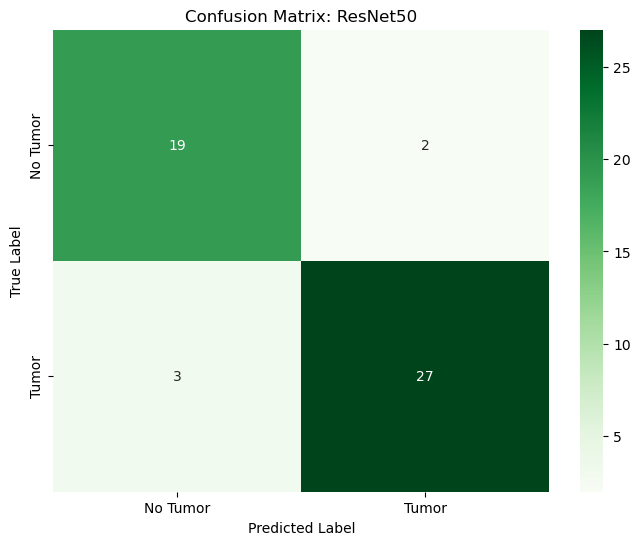

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting once — ensure x_test has shape (num_samples, img_height, img_width, 3)
y_pred_resnet50_probs = model_resnet50.predict(x_test, batch_size=32)  
y_pred_resnet50 = (y_pred_resnet50_probs > 0.5).astype(int)

# Generating confusion matrix
cm_resnet50 = confusion_matrix(y_test, y_pred_resnet50)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet50, annot=True, fmt='d', cmap='Greens', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title("Confusion Matrix: ResNet50")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# ResNet50 Accuracy and Loss

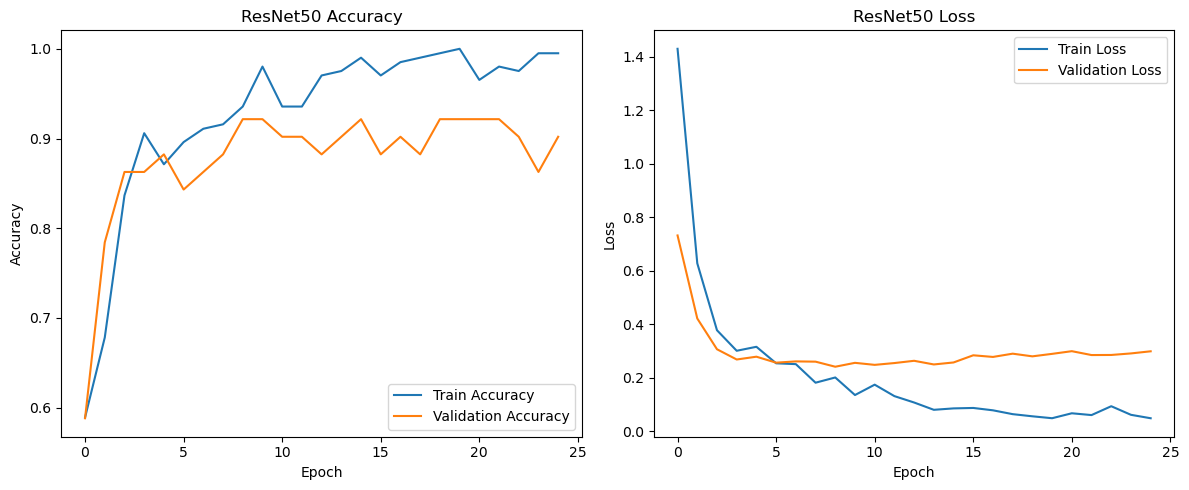

In [21]:
# ResNet50 Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


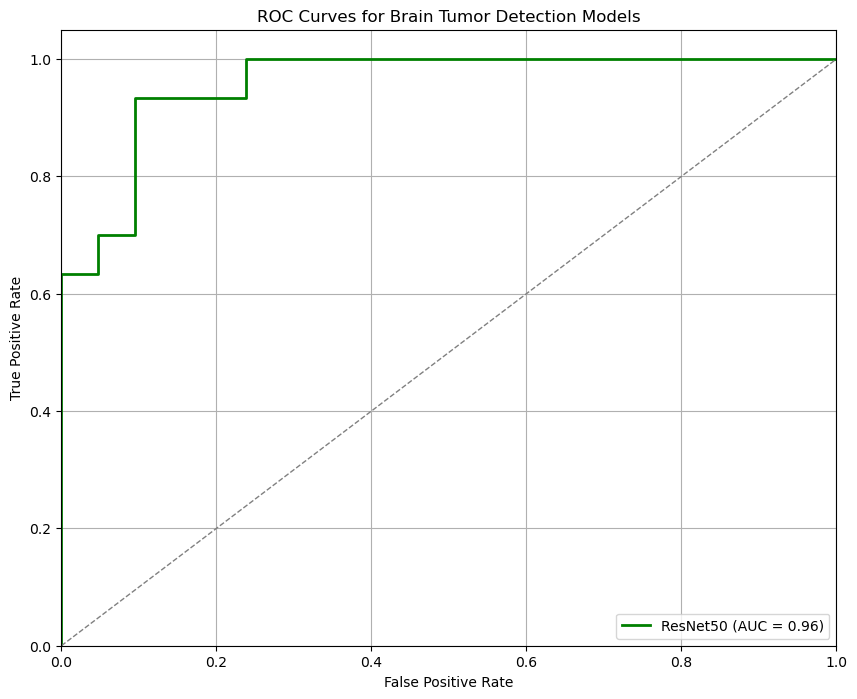

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# For ResNet50
y_pred_resnet50_prob = model_resnet50.predict(x_test)  # predicted probabilities
fpr_resnet50, tpr_resnet50, thresholds_resnet50 = roc_curve(y_test, y_pred_resnet50_prob)
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Plotting all ROC curves
plt.figure(figsize=(10, 8))

# ResNet50 ROC curve
plt.plot(fpr_resnet50, tpr_resnet50, color='green', lw=2, label=f'ResNet50 (AUC = {roc_auc_resnet50:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Brain Tumor Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Training the EfficientnetB7 model

In [23]:
from tensorflow.keras.applications import EfficientNetB7

# Load the pre-trained EfficientNetB7 model without the top (classification) layer
base_model_efficientnet = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of EfficientNetB7
for layer in base_model_efficientnet.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Final model
model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=x)

# Compile the model
model_efficientnet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_efficientnet.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      2,048 │ block1a_se_excit

 Total params: 64,425,624 (245.76 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [24]:
# Train the EfficientNetB7 model
history_efficientnet = model_efficientnet.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6758 - loss: 0.5819 - val_accuracy: 0.8824 - val_loss: 0.3826
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7738 - loss: 0.4951 - val_accuracy: 0.8431 - val_loss: 0.3647
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7485 - loss: 0.4339 - val_accuracy: 0.8431 - val_loss: 0.3259
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8580 - loss: 0.3391 - val_accuracy: 0.8431 - val_loss: 0.3118
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8245 - loss: 0.3527 - val_accuracy: 0.8627 - val_loss: 0.3032
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8708 - loss: 0.2928 - val_accuracy: 0.8431 - val_loss: 0.3209
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8506 - loss: 0.3182 - val_accuracy: 0.8431 - val_loss: 0.3344
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.9070 - loss: 0.2131 - val_accuracy: 0.8431 - val_loss: 0.2968
Epoch 9/

# Confusion Matrix :- EfficientNetB7

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


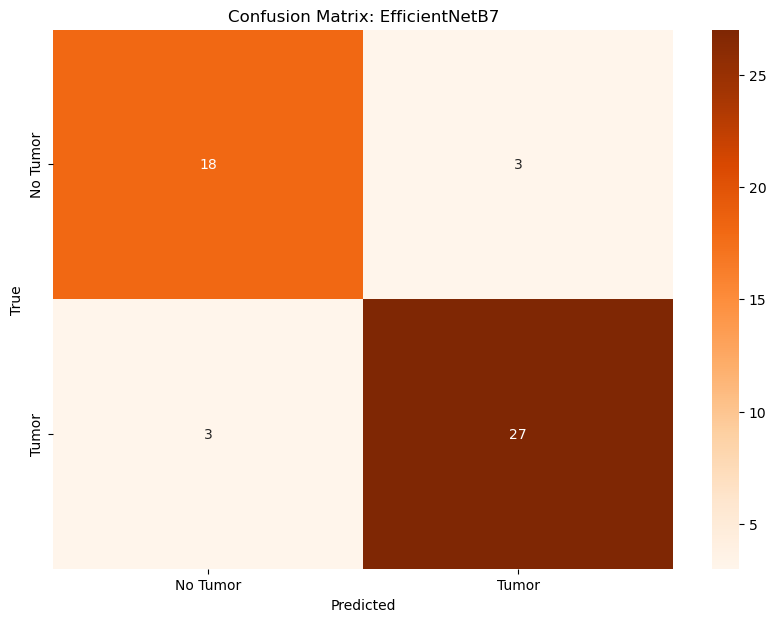

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For EfficientNetB7
y_pred_efficientnet = (model_efficientnet.predict(x_test) > 0.5)
cm_efficientnet = confusion_matrix(y_test, y_pred_efficientnet)

# Plot confusion matrix for EfficientNetB7
plt.figure(figsize=(10, 7))
sns.heatmap(cm_efficientnet, annot=True, fmt='d', cmap='Oranges', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title("Confusion Matrix: EfficientNetB7")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# EfficientNetB7 Accuracy and Loss

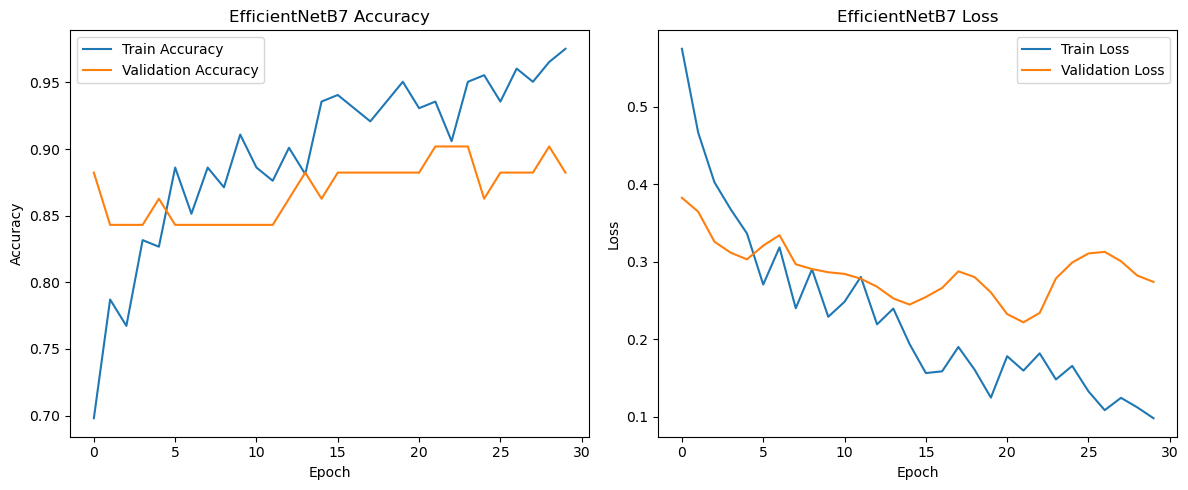

In [26]:
# EfficientNetB7 Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB7 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB7 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 970ms/step


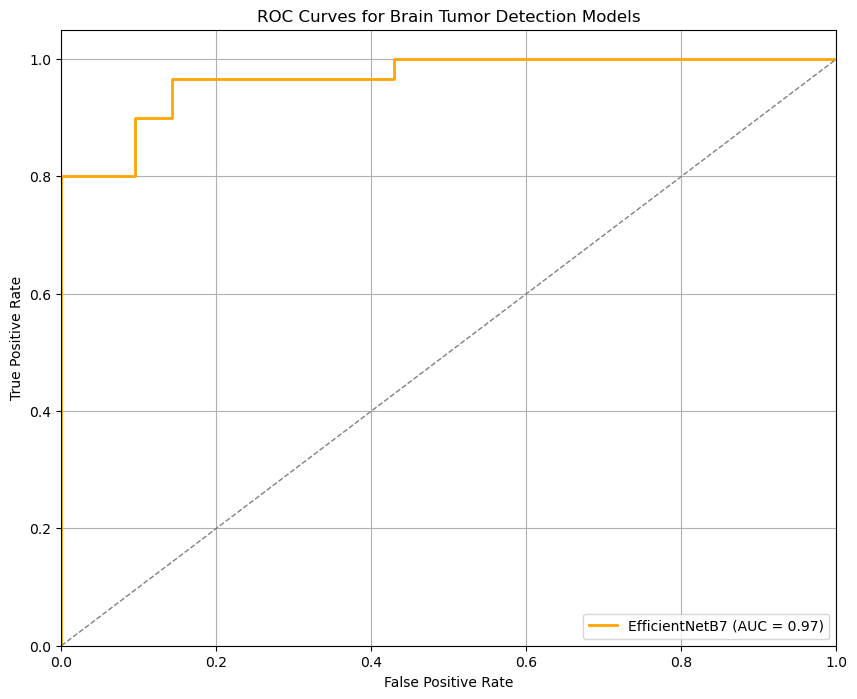

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# For EfficientNetB7
y_pred_efficientnet_prob = model_efficientnet.predict(x_test)  # predicted probabilities
fpr_efficientnet, tpr_efficientnet, thresholds_efficientnet = roc_curve(y_test, y_pred_efficientnet_prob)
roc_auc_efficientnet = auc(fpr_efficientnet, tpr_efficientnet)

# Plotting all ROC curves
plt.figure(figsize=(10, 8))

# EfficientNetB7 ROC curve
plt.plot(fpr_efficientnet, tpr_efficientnet, color='orange', lw=2, label=f'EfficientNetB7 (AUC = {roc_auc_efficientnet:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Brain Tumor Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Model Evaluation On Test Data

In [28]:
# Evaluating VGG16
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(x_test, y_test)
print(f"VGG16 Test Accuracy: {test_acc_vgg16}")
print(f"VGG16 Test Loss: {test_loss_vgg16}")

# Evaluating ResNet50
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(x_test, y_test)
print(f"ResNet50 Test Accuracy: {test_acc_resnet50}")
print(f"ResNet50 Test Loss: {test_loss_resnet50}")

# Evaluating EfficientNetB7
test_loss_efficientnet, test_acc_efficientnet = model_efficientnet.evaluate(x_test, y_test)
print(f"EfficientNetB7 Test Accuracy: {test_acc_efficientnet}")
print(f"EfficientNetB7 Test Loss: {test_loss_efficientnet}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step - accuracy: 0.8329 - loss: 0.5248
VGG16 Test Accuracy: 0.843137264251709
VGG16 Test Loss: 0.5705481767654419
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.8930 - loss: 0.3154
ResNet50 Test Accuracy: 0.9019607901573181
ResNet50 Test Loss: 0.2990500032901764
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 974ms/step - accuracy: 0.8591 - loss: 0.3227
EfficientNetB7 Test Accuracy: 0.8823529481887817
EfficientNetB7 Test Loss: 0.2740570306777954


In [29]:
# Creating a comparison dataframe
import pandas as pd
model_comparison = pd.DataFrame({
    'Model': ['VGG16', 'ResNet50', 'EfficientNetB7'],
    'Test Accuracy': [test_acc_vgg16, test_acc_resnet50, test_acc_efficientnet],
    'Test Loss': [test_loss_vgg16, test_loss_resnet50, test_loss_efficientnet]
})

# Display the comparison
print(model_comparison)

            Model  Test Accuracy  Test Loss
0           VGG16       0.843137   0.570548
1        ResNet50       0.901961   0.299050
2  EfficientNetB7       0.882353   0.274057


# Comparision of all the Algorithms

In [30]:
# Evaluate the CNN model on the test set
test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test_norm, y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7024 - loss: 0.7197


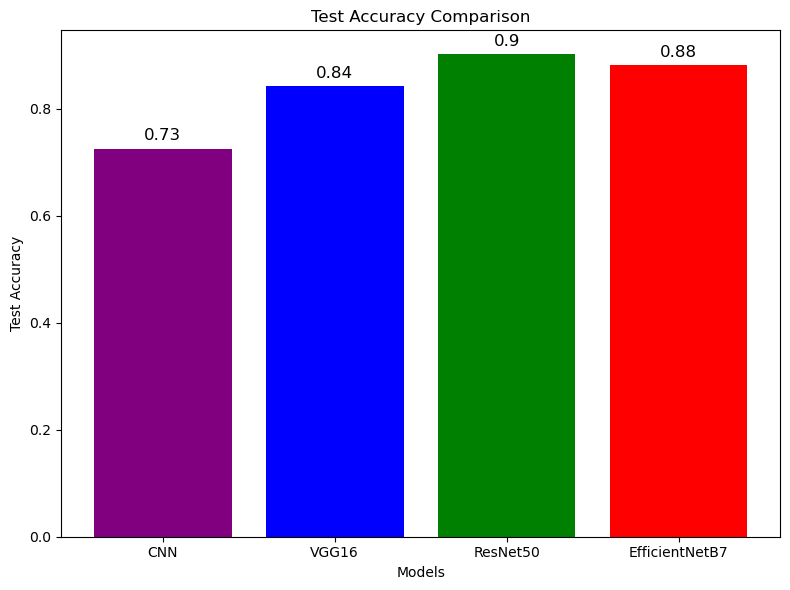

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following test accuracies are already defined:
# test_acc_cnn, test_acc_vgg16, test_acc_resnet50, test_acc_efficientnet

test_accuracies = [test_acc_cnn, test_acc_vgg16, test_acc_resnet50, test_acc_efficientnet]
models = ['CNN', 'VGG16', 'ResNet50', 'EfficientNetB7']

# Bar graph for test accuracy comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(models, test_accuracies, color=['purple', 'blue', 'green', 'red'])

# Adding title and labels
plt.title('Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')

# Showing the accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


# Saving the Best Model

In [42]:
# Save the trained ResNet50 model
model_resnet50.save('ResNet50_best_model.h5')
print("ResNet50 model saved successfully as 'ResNet50_best_model.h5'")


ResNet50 model saved successfully as 'ResNet50_best_model.h5'


In [43]:
from tensorflow.keras.models import load_model

# Load the saved ResNet50 model
loaded_resnet50_model = load_model('ResNet50_best_model.h5')
print(" ResNet50 model loaded successfully!")


 ResNet50 model loaded successfully!


In [41]:
# Predict on the entire test set
batch_predictions = loaded_resnet50_model.predict(x_test)

# Convert probabilities to binary labels
batch_pred_classes = (batch_predictions > 0.5).astype("int32")

# Print first 10 predictions
print("First 10 predictions:", batch_pred_classes[:10].flatten())


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
First 10 predictions: [1 1 1 0 1 1 1 1 1 0]
